# Endothelial cells

In [1]:
import scanpy as sc
from tidyverse.dummy import *
from sctools.scplotting import recolor
import gc
import pertpy as pt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
from sctools.composition import compositional_pca, plot_pca_loadings
plt.rcParams["figure.figsize"] = (4,3)

from prop_utils import annotate_qval_to_scCODA_result, renamer

import sys
sys.path.append('..')
from util import load_celltype
from colormaps import color_dict_diagnosis, cmap_subtypes

Importing tidyverse


/tmp/ipykernel_148406/3630650438.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [2]:
mkdir /tmp/proportions

mkdir: cannot create directory ‘/tmp/proportions’: File exists


In [3]:
plotfolder = '/tmp/proportions/Endothelial_proportions/'
import os 
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

# SCCODA

In [11]:
A = load_celltype('Endothelial')
A.obs.diagnosis = pd.Categorical(A.obs.diagnosis)
recolor(A, 'diagnosis', color_dict_diagnosis)

In [8]:
diagnosis_ordered = ['NE', 'M','D','T', 'NS']

In [9]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    A,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="leiden",
    sample_identifier="samplename",
    covariate_obs=['samplename','diagnosis', 'procedure', 'patient'],
)
sccoda_data["coda"].obs['n_cells'] = sccoda_data["coda"].X.sum(1)
sccoda_data["coda"].obs['diagnosis'] = pd.Categorical(sccoda_data["coda"].obs['diagnosis'], diagnosis_ordered)

data_scanpy_1 = sccoda_data["coda"]

In [17]:
cluster_order = [
    '3','4', # arterial
    '0','6','10', # ven
    '9','2','7','5','1', # cap
    '8' # lymph
]

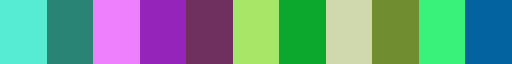

In [12]:
# reorder a little,
from matplotlib.colors import ListedColormap
_cm_colors= cmap_subtypes.colors
_cm_colors = np.array(_cm_colors)[[0,1, 
                                   10,11,12,
                                  2,3,4,5,6, 7
                                  ]]
cmap_subtypes = ListedColormap(
    _cm_colors
)
cmap_subtypes

In [13]:
leiden_color_dict = dict(zip(cluster_order, cmap_subtypes.colors ))
_tmp = [leiden_color_dict[c] for c in A.obs.leiden.cat.categories]

if not 'leiden_colors_backup' in A.uns:
    A.uns['leiden_colors_backup']= A.uns['leiden_colors']
A.uns['leiden_colors'] = _tmp

## Proportions

/tmp/ipykernel_147987/1555712036.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


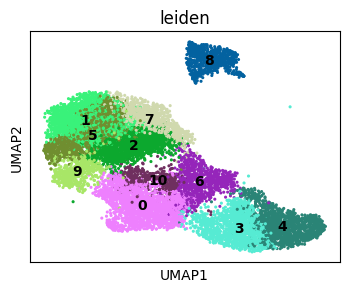

In [14]:
set_matplotlib_formats('png')
sc.pl.umap(A, color=['leiden'], legend_loc='on data', size=20)

In [15]:
set_matplotlib_formats('png')

/tmp/ipykernel_147987/2623958728.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


/tmp/ipykernel_147987/87440585.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


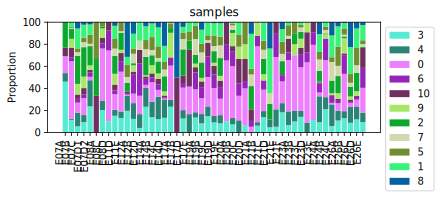

In [16]:
order = []
samplenames = A.obs.samplename.astype(str).unique().tolist()
for d in diagnosis_ordered:
    order.extend(sorted(data_scanpy_1.obs.loc[samplenames].query('diagnosis==@d').index))
    
set_matplotlib_formats('svg')
fig = sccoda_model.plot_stacked_barplot(
    data_scanpy_1[:, cluster_order],
    modality_key="coda",
    feature_name="samples",
    figsize=(6,2), show=False, palette=cmap_subtypes
)
plt.xticks(rotation=90);
fig.figure.savefig(f'{plotfolder}/Bcell_proportions_per_sample.svg')

## CODA-PCA

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 1353.05it/s]


<Axes: xlabel='leiden'>

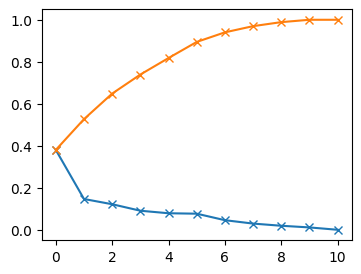

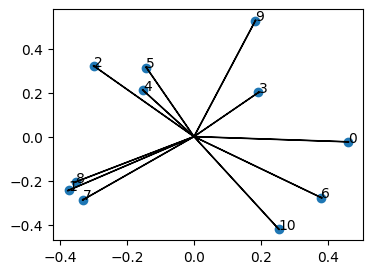

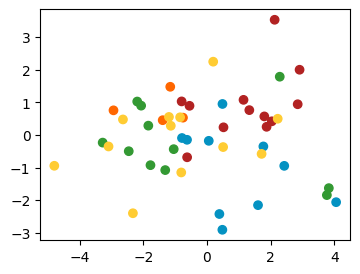

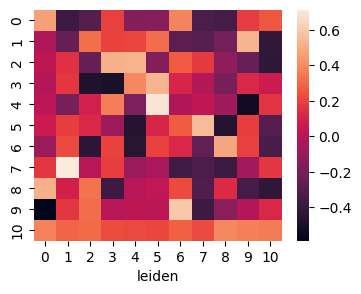

In [18]:
pca, scaler, x_pca_posterior, principal_components_df = compositional_pca(data_scanpy_1)
plt.plot(pca.explained_variance_ratio_, 'x-')
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'x-')

# plot_pca_with_uncertainty()
plt.figure()
plot_pca_loadings(principal_components_df)

plt.figure()
plt.scatter(x_pca_posterior[:,0], x_pca_posterior[:,1], c=[color_dict_diagnosis[_] for _ in data_scanpy_1.obs.diagnosis])

plt.figure()
sns.heatmap(principal_components_df)

## Barplots

/tmp/ipykernel_147987/2484048808.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
/tmp/ipykernel_147987/2484048808.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


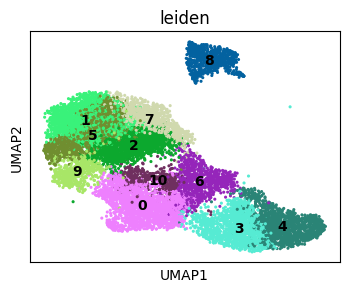

In [19]:
set_matplotlib_formats('png')
sc.pl.umap(A, color=['leiden'], legend_loc='on data', size=20, show=False)
plt.savefig(f'{plotfolder}/Endothelial_umap.png')
set_matplotlib_formats('png')

/tmp/ipykernel_147987/165465936.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
/tmp/ipykernel_147987/165465936.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


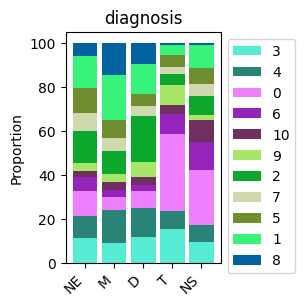

In [20]:
set_matplotlib_formats('svg')
fig = sccoda_model.plot_stacked_barplot(
    data_scanpy_1[:, cluster_order],
    modality_key="coda",
    feature_name="diagnosis",
    figsize=(2,3), show=False, palette=cmap_subtypes
)
fig.figure.savefig(f'{plotfolder}/Bcell_proportions_per_diagnosis.svg')
set_matplotlib_formats('png')

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 2 x 1 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/Endothelial_proportions//proportions_per_diagnosis_ncells.svg


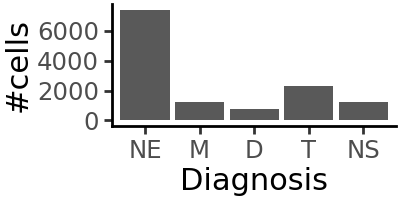

In [21]:
p = pn.ggplot(pd.DataFrame({'n_cells': data_scanpy_1.obs.groupby('diagnosis').n_cells.sum()}).reset_index(), pn.aes(x='diagnosis', y='n_cells')) + pn.geom_bar(stat='identity') \
+ pn.theme_classic() + pn.theme(figure_size=(2,1)) + pn.labs(x='Diagnosis', y='#cells')
p.save(f'{plotfolder}/proportions_per_diagnosis_ncells.svg')
p

In [22]:
q = pd.crosstab(
    pd.Series(pd.Categorical(A.obs.leiden, categories=cluster_order), name='leiden', index=A.obs.leiden.index),
    A.obs.diagnosis
)
norm_freqs = q.div( q.sum(1), axis=0)
norm_freqs = norm_freqs.unstack().reset_index().rename({0:'frequency'}, axis=1)
norm_freqs.diagnosis = pd.Categorical(norm_freqs.diagnosis, categories=diagnosis_ordered)

/tmp/ipykernel_147987/276872926.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 2 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/Endothelial_proportions//Endothelial_proportions_per_cluster.svg
/tmp/ipykernel_147987/276872926.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


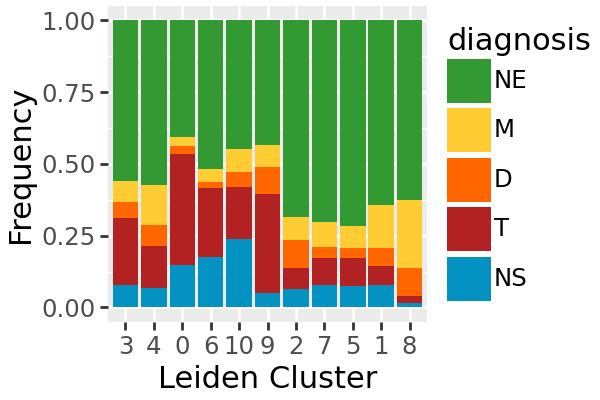

In [23]:
set_matplotlib_formats('svg')
p=pn.ggplot(
    norm_freqs,
    pn.aes(x='leiden', y='frequency', fill='diagnosis')) + pn.geom_bar(stat='identity') \
+ pn.theme(figure_size=(3,2)) + pn.scale_fill_manual(color_dict_diagnosis) + pn.labs(x='Leiden Cluster', y='Frequency')
p.save(f'{plotfolder}/Endothelial_proportions_per_cluster.svg')
set_matplotlib_formats('png')
p

In [24]:
set_matplotlib_formats('png')

/tmp/ipykernel_147987/2623958728.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


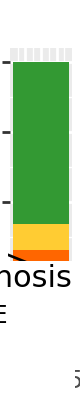

In [25]:
overall_props = A.obs.diagnosis.value_counts()
overall_props = overall_props/overall_props.sum()
overall_props = overall_props.loc[diagnosis_ordered]

_ddd = pd.DataFrame(overall_props).reset_index().rename({'count': 'frequency'}, axis=1)
_ddd.diagnosis = pd.Categorical(_ddd.diagnosis, categories=diagnosis_ordered)

pn.ggplot(
    _ddd,
    pn.aes(x=1, y='frequency', fill='diagnosis')) + pn.geom_bar(stat='identity') \
+ pn.theme(figure_size=(7,2)) + pn.scale_fill_manual(color_dict_diagnosis) + pn.theme(figure_size=(0.4,2)) + pn.labs(x='', y='Frequency')

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 1 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/Endothelial_proportions//proportions_per_cluster_ncells.svg


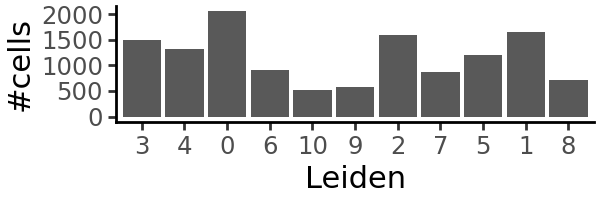

In [26]:
p = pn.ggplot(pd.DataFrame({'n_cells': q.reset_index().melt(id_vars=['leiden']).groupby('leiden').value.sum()}).reset_index(), pn.aes(x='leiden', y='n_cells')) + pn.geom_bar(stat='identity') \
 + pn.theme_classic() + pn.theme(figure_size=(3,1)) + pn.labs(x='Leiden', y='#cells')
p.save(f'{plotfolder}/proportions_per_cluster_ncells.svg')
p

## MCMC

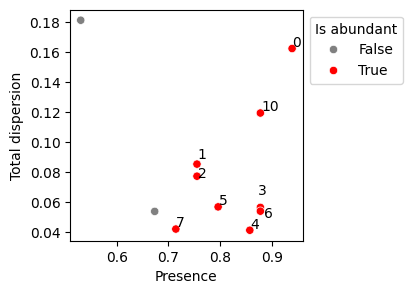

In [28]:
sccoda_model.plot_rel_abundance_dispersion_plot(sccoda_data, figsize=(3,3), abundant_threshold=0.7); plt.show()

### diag + procedure

In [26]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    # formula="TRG",
    formula="C(diagnosis, Treatment('NE')) + patient + procedure",
    reference_cell_type="5",
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda")

• Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|███████████| 11000/11000 [15:00<00:00, 12.21it/s, 511 steps of size 9.68e-03. acc. prob=0.83]


AnnData object with n_obs × n_vars = 49 × 11
    obs: 'samplename', 'patient', 'procedure', 'diagnosis', 'n_cells'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', "effect_df_C(diagnosis, Treatment('NE'))[T.M]", "effect_df_C(diagnosis, Treatment('NE'))[T.D]", "effect_df_C(diagnosis, Treatment('NE'))[T.T]", "effect_df_C(diagnosis, Treatment('NE'))[T.NS]", 'effect_df_patient[T.E08]', 'effect_df_patient[T.E11]', 'effect_df_patient[T.E12]', 'effect_df_patient[T.E14]', 'effect_df_patient[T.E17]', 'effect_df_patient[T.E19]', 'effect_df_patient[T.E20]', 'effect_df_patient[T.E21]', 'effect_df_patient[T.E23]', 'effect_df_patient[T.E24]', 'effect_df_patient[T.E26]', 'effect_df_procedure[T.resection]'

In [27]:
sccoda_model.set_fdr(sccoda_data, est_fdr=0.05)
scCODA_result = sccoda_model.get_effect_df(sccoda_data)
scCODA_result['pvalue'] = 1-scCODA_result['Inclusion probability']
scCODA_result['log10pvalue'] = np.log10(scCODA_result['pvalue'])

scCODA_result = annotate_qval_to_scCODA_result(scCODA_result)

scCODA_result.to_csv(f'{plotfolder}/MCMC_diag_procedure_patient.csv')
scCODA_result[scCODA_result['Final Parameter'] != 0]

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


Final Parameter  HDI 3%  HDI 97%  \
Covariate                         Cell Type                                     
C(diagnosis, Treatment('NE'))T.M  0                -0.593121  -1.086   -0.131   
                                  1                 0.628988   0.186    1.067   
                                  8                 0.651790  -0.001    1.158   
C(diagnosis, Treatment('NE'))T.T  0                 1.015243   0.553    1.437   
                                  2                -0.609684  -1.028    0.001   
                                  3                 0.511815  -0.001    0.845   
                                  6                 0.886227   0.401    1.383   
                                  8                -1.067196  -1.716   -0.435   
                                  9                 1.323008   0.764    1.824   
C(diagnosis, Treatment('NE'))T.NS 0                 0.894254   0.456    1.316   
                                  2                -0.755216  -1.345   -0.120   
                                  6                 1.050891   0.517    1.531   
                                  8                -0.939501  -1.742   -0.217   
                                  10                1.216943   0.711    1.688   
patientT.E12                      0                -1.026323  -1.748   -0.206   
                                  8                 1.385821   0.617    2.203   
patientT.E14                      0                -0.559344  -1.085    0.010   
patientT.E17                      0                -0.621969  -1.092    0.003   
procedureT.resection              0                -1.219163  -1.683   -0.733   
                                  1                 1.104389   0.548    1.638   
                                  9                -0.691311  -1.241   -0.156   
                                  10               -1.023170  -1.521   -0.486   

                                                SD  Inclusion probability  \
Covariate                         Cell Type                                 
C(diagnosis, Treatment('NE'))T.M  0          0.287                 0.9148   
                                  1          0.257                 0.9604   
                                  8          0.350                 0.9003   
C(diagnosis, Treatment('NE'))T.T  0          0.229                 1.0000   
                                  2          0.324                 0.8590   
                                  3          0.268                 0.8534   
                                  6          0.268                 0.9890   
                                  8          0.348                 0.9893   
                                  9          0.276                 1.0000   
C(diagnosis, Treatment('NE'))T.NS 0          0.218                 0.9997   
                                  2          0.366                 0.9167   
                                  6          0.264                 1.0000   
                                  8          0.439                 0.9396   
                                  10         0.253                 1.0000   
patientT.E12                      0          0.426                 0.9792   
                                  8          0.447                 0.9850   
patientT.E14                      0          0.341                 0.8843   
patientT.E17                      0          0.318                 0.9340   
procedureT.resection              0          0.257                 1.0000   
                                  1          0.282                 1.0000   
                                  9          0.335                 0.8995   
                                  10         0.283                 0.9959   

                                             Expected Sample  \
Covariate                         Cell Type                    
C(diagnosis, Treatment('NE'))T.M  0                50.826235   
                                  1                19.26945

In [38]:
_q = scCODA_result.reset_index()
a = pd.crosstab(_q['Covariate'].replace(renamer),
    _q['Cell Type'], 
    values=_q['log2-fold change']* (_q['Final Parameter'] !=0), aggfunc=np.mean).replace({np.nan: 0})

/tmp/ipykernel_3933813/1160416068.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


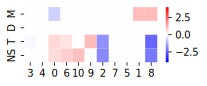

In [29]:
set_matplotlib_formats('svg')

fig, ax = plt.subplots(figsize=(3, 1))
sns.heatmap(a.loc[['M','D','T','NS'], cluster_order], cmap=plt.cm.bwr, vmin=-4, vmax=4)
# plt.title('Log2 fold change (wrt NE)')
plt.xlabel(None)
plt.ylabel(None)
fig.savefig(f'{plotfolder}/Bcell_scCODA.svg')

In [40]:
_q = scCODA_result.reset_index()
a = pd.crosstab(_q['Covariate'].replace(renamer),
    _q['Cell Type'], 
    values=_q['log2-fold change'], aggfunc=np.mean).replace({np.nan: 0})
a

Cell Type,0,1,10,2,3,4,5,6,7,8,9
Covariate,,,,,,,,,,,
D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M,-0.729731,1.033398,0.125961,0.125961,0.125961,0.125961,0.125961,0.125961,0.125961,1.066295,0.125961
NS,0.532017,-0.758118,0.997559,-1.847664,-0.758118,-0.758118,-0.758118,0.757997,-0.758118,-2.113532,-0.758118
T,0.624248,-0.840438,-0.840438,-1.720026,-0.102045,-0.840438,-0.840438,0.438118,-0.840438,-2.380076,1.068260
patientT.E08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
patientT.E11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
patientT.E12,-1.306875,0.173796,0.173796,0.173796,0.173796,0.173796,0.173796,0.173796,0.173796,2.173113,0.173796
patientT.E14,-0.594755,0.212208,0.212208,0.212208,0.212208,0.212208,0.212208,0.212208,0.212208,0.212208,0.212208
patientT.E17,-0.666469,0.230843,0.230843,0.230843,0.230843,0.230843,0.230843,0.230843,0.230843,0.230843,0.230843


/tmp/ipykernel_3933813/3154158120.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


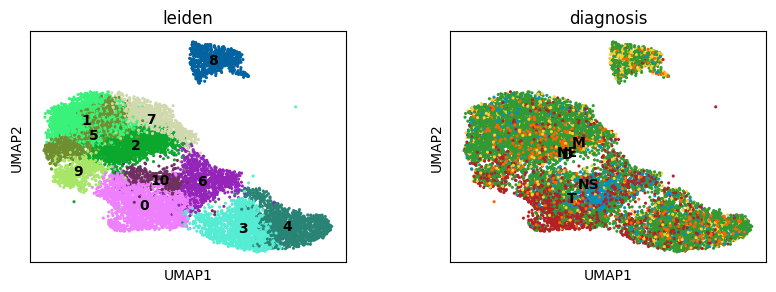

In [41]:
set_matplotlib_formats('png')
sc.pl.umap(A, color=['leiden', 'diagnosis'], legend_loc='on data', size=20)

# markers

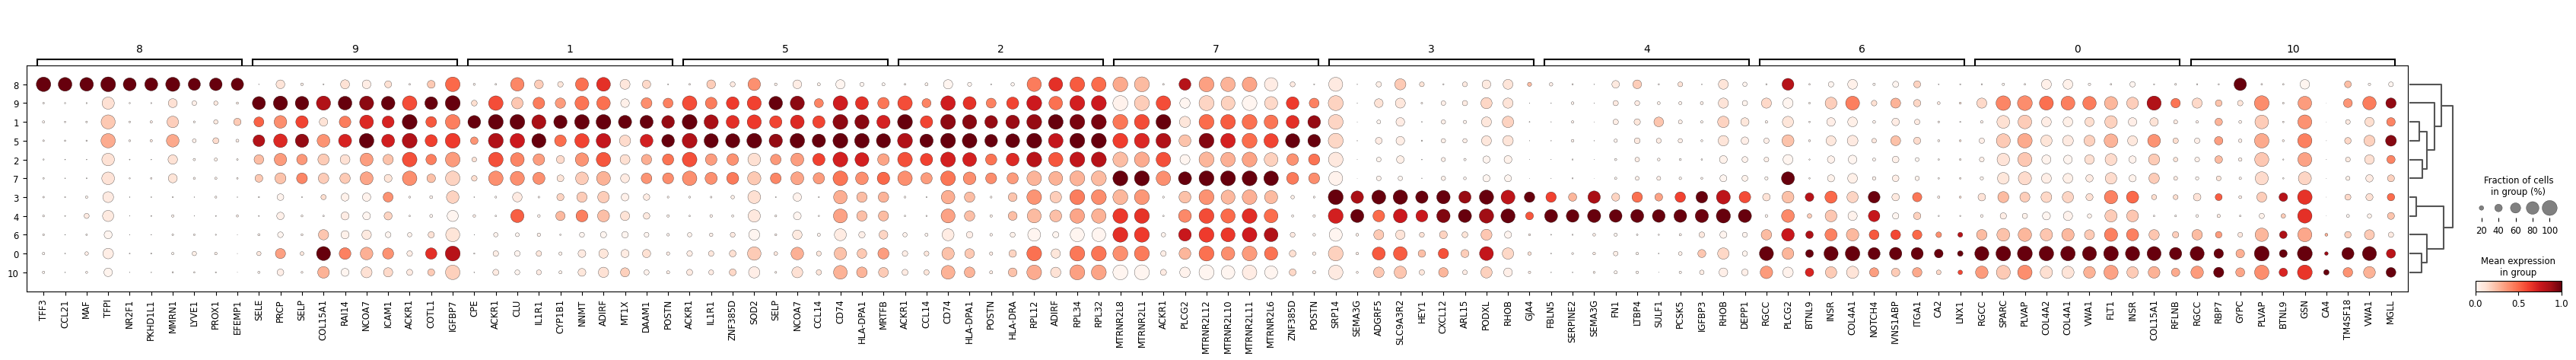

In [42]:
sc.tl.dendrogram(A, groupby='leiden')
sc.pl.rank_genes_groups_dotplot(A, standard_scale='var')

/tmp/ipykernel_148406/894638251.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


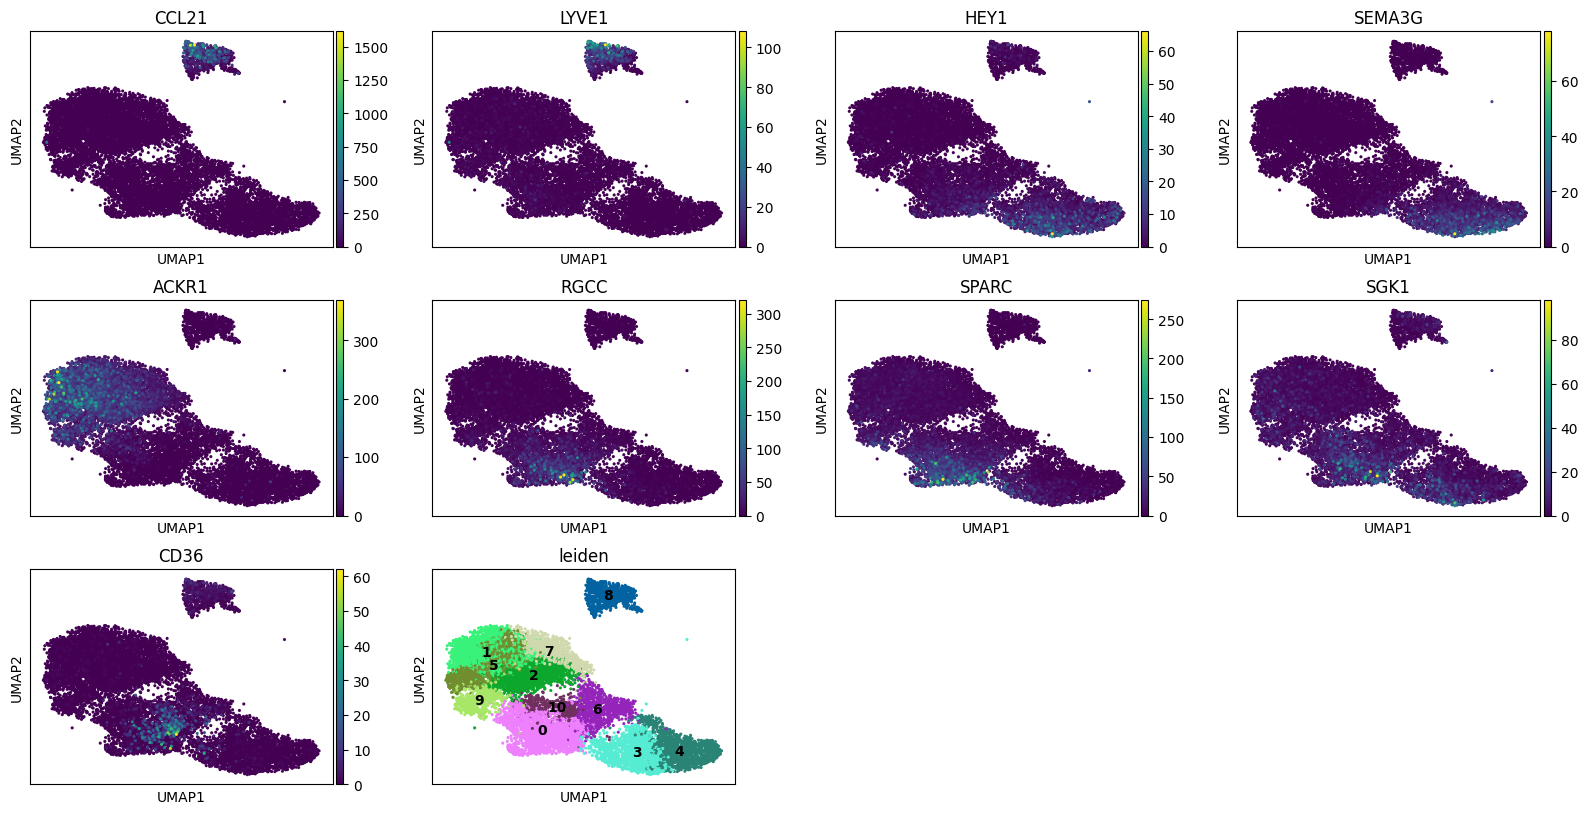

/tmp/ipykernel_148406/894638251.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


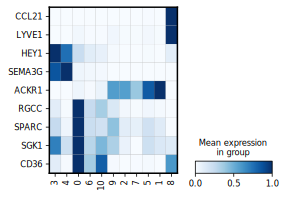

In [18]:
genes =['CCL21','LYVE1','HEY1', 'SEMA3G', 'ACKR1', 'RGCC','SPARC','SGK1', 'CD36'] # 'PLVAP', 'VWA1'
set_matplotlib_formats('png')
sc.pl.umap(A, color=genes+['leiden'], legend_loc='on data', size=20)

B = A.copy()
B.obs['leiden'] = pd.Categorical(B.obs['leiden'], categories=cluster_order)
set_matplotlib_formats('svg')

sc.pl.matrixplot(B, var_names=genes, groupby='leiden', standard_scale='var', swap_axes=True, show=False, #order=cluster_order
                figsize=(4,3), cmap='Blues')
plt.savefig(f'{plotfolder}/Endothelial_markers_matrix.svg')